In [1]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNet
from keras.models import Sequential, Model

<h1>Loading The data</h1>

<h2>Reading CSV Files</h2>

In [2]:
test_images = pd.read_csv('csvTestImages 3360x1024.csv', header=None)
test_label= pd.read_csv('csvTestLabel 3360x1.csv', header=None)-1

train_images =  pd.read_csv('csvTrainImages 13440x1024.csv', header=None) 
train_label = pd.read_csv('csvTrainLabel 13440x1.csv', header=None)-1

<h1>Analyzing Data</h1>

In [3]:
# Display basic information about the datasets
print("Training set shape:", train_images.shape)
print("Testing set shape:", test_images.shape)

Training set shape: (13440, 1024)
Testing set shape: (3360, 1024)


<h1>Data Preprocessing</h1>

In [4]:
image_size = (32, 32)

train_images= train_images.values.reshape(-1, *image_size,1)
test_images = test_images.values.reshape(-1, *image_size,1)

train_images.shape, test_images.shape

((13440, 32, 32, 1), (3360, 32, 32, 1))

In [5]:
# Replicate single channel into three channels
train_images = np.repeat(train_images, 3, axis=-1)
test_images = np.repeat(test_images, 3, axis=-1)

In [6]:
train_images = train_images.astype('float32')
test_images  = test_images.astype('float32')
# Normalize pixel values to the range [0, 1]
train_images = train_images / 255.0
test_images= test_images / 255.0

In [7]:
# Change the labels from categorical to one-hot encoding
train_label_one_hot = to_categorical(train_label)
test_label_one_hot = to_categorical(test_label)

# Display the change for category label using one-hot encoding
print('Original label:', train_label.iloc[0].values[0])
print('After conversion to one-hot:', train_label_one_hot[0])

Original label: 0
After conversion to one-hot: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [8]:
print('Original label:', train_label.iloc[9].values[0])
print('After conversion to one-hot:', train_label_one_hot[9])

Original label: 1
After conversion to one-hot: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


<h1>Data Visualization</h1>

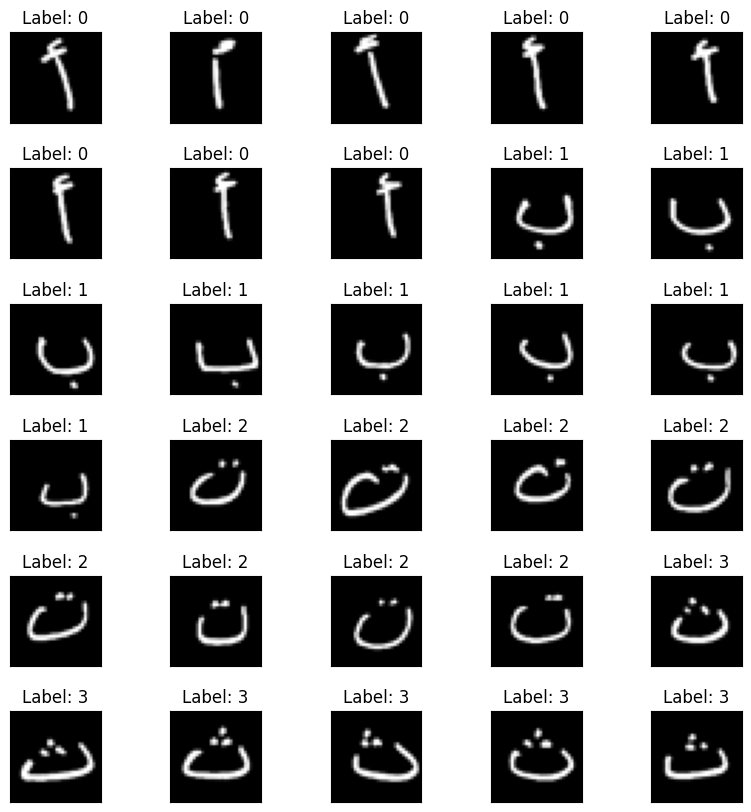

In [9]:
# Display a few images from the training set
plt.figure(figsize=(10, 10))
for i in range(30):
    plt.subplot(6, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[i, :, :, 0].T, cmap='gray')  # Display the first channel (grayscale)
    plt.title(f"Label: {train_label.iloc[i, 0]}")
    plt.subplots_adjust(hspace=0.5)

plt.show()

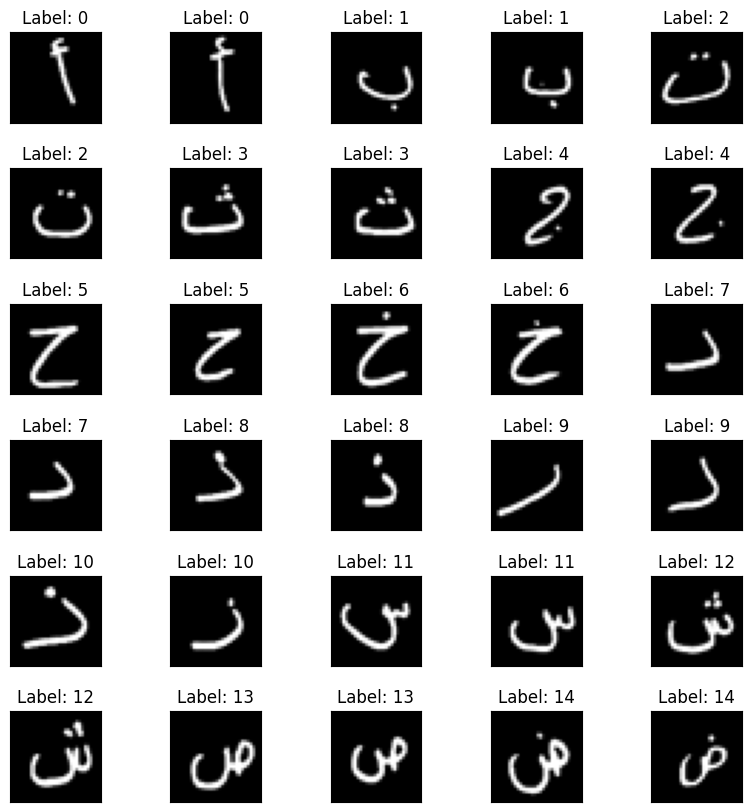

In [10]:
# Display a few images from the training set
plt.figure(figsize=(10, 10))
for i in range(30):
    plt.subplot(6, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_images[i, :, :, 0].T, cmap='gray')  # Display the first channel (grayscale)
    plt.title(f"Label: {test_label.iloc[i, 0]}")
    plt.subplots_adjust(hspace=0.5)

plt.show()

<h1>Data Augmentation</h1>

In [11]:
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

<h1>The Network</h1>

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, ReLU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from tensorflow.keras.models import clone_model
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf

In [14]:
epochs = 80
batch_size = 120

<h1>Loading a pretrained model</h1>

In [15]:
from keras.models import load_model
from keras.utils import CustomObjectScope
from keras.metrics import top_k_categorical_accuracy

# Define the custom metric function
def top_3_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

# Load the model with the custom metric function
with CustomObjectScope({'top_3_categorical_accuracy': top_3_categorical_accuracy}):
    base_model = load_model('model.h5')

The code loads a pretrained (model.h5) with a custom metric function, 'top_3_categorical_accuracy', for evaluating the top-3 categorical accuracy during model training. The 'CustomObjectScope' is used to ensure the correct recognition of the custom metric when loading the model. The loaded model, stored in 'base_model', can be utilized for predictions or further fine-tuning.

Here is the refrence of the pretrained model: https://www.kaggle.com/code/bryanb/cnn-for-handwritten-letters-classification

In [16]:
# Remove the last layer
x = base_model.layers[-2].output  # Assuming the last layer is Dense

# Add a new dense layer with 28 units
output = Dense(28, activation='softmax')(x)

# Create the updated model
model = Model(inputs=base_model.input, outputs=output)

We removed the last layer from the loaded 'base_model' and added a new Dense layer with 28 units and softmax activation. The resulting model represents the modified architecture, preserving the pre-trained layers and introducing a new output layer.

<h1>Compiling the Model</h1>

In [17]:
# Compile the model with Adam optimizer and learning rate 0.001
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# Display the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3_input (InputLayer  [(None, 32, 32, 3)]       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 128)       131200    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 128)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 12, 12, 128)       0     

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
model_history = model.fit(datagen.flow(train_images, train_label_one_hot, batch_size=batch_size),
                          epochs=epochs,
                          batch_size=batch_size,
                          verbose=1,
                          validation_data=(test_images, test_label_one_hot),
                          callbacks=[early_stopping])

Epoch 1/80


112/112 [==============================] - 26s 223ms/step - loss: 3.8717 - accuracy: 0.0449 - val_loss: 3.2430 - val_accuracy: 0.0670
Epoch 2/80
112/112 [==============================] - 24s 211ms/step - loss: 3.2334 - accuracy: 0.0580 - val_loss: 3.1519 - val_accuracy: 0.0702
Epoch 3/80
112/112 [==============================] - 23s 204ms/step - loss: 3.1801 - accuracy: 0.0615 - val_loss: 3.0979 - val_accuracy: 0.0762
Epoch 4/80
112/112 [==============================] - 23s 201ms/step - loss: 3.1172 - accuracy: 0.0596 - val_loss: 2.9623 - val_accuracy: 0.0940
Epoch 5/80
112/112 [==============================] - 23s 201ms/step - loss: 3.0628 - accuracy: 0.0791 - val_loss: 2.9106 - val_accuracy: 0.1342
Epoch 6/80
112/112 [==============================] - 22s 200ms/step - loss: 2.9558 - accuracy: 0.1058 - val_loss: 2.7287 - val_accuracy: 0.1747
Epoch 7/80
112/112 [==============================] - 22s 200ms/step - loss: 2.7793 - accuracy: 0.1401 - val_loss: 2.3066 - val_

We can observe that the training loss (loss) is decreasing over epochs, indicating that the model is learning and adapting to the training data.
Thetestingn loss (val_loss) is also decreasing, suggesting that the model is generalizing well to unseen data

Also, the training accuracy (accuracy) is increasing, indicating that the model is performing well on the training data.
Thetestingn accuracy (val_accuracy) is also increasing, suggesting good generalization to thetestingn set..

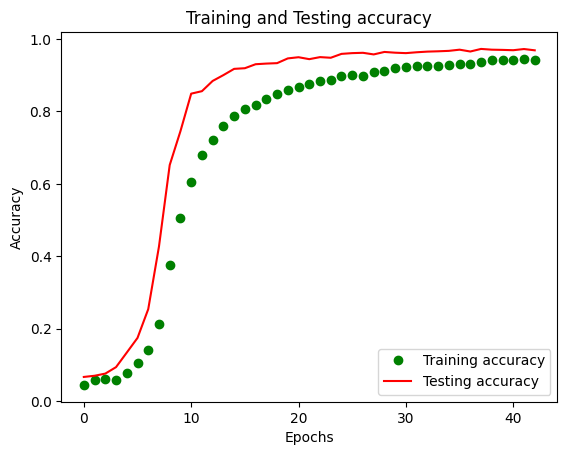

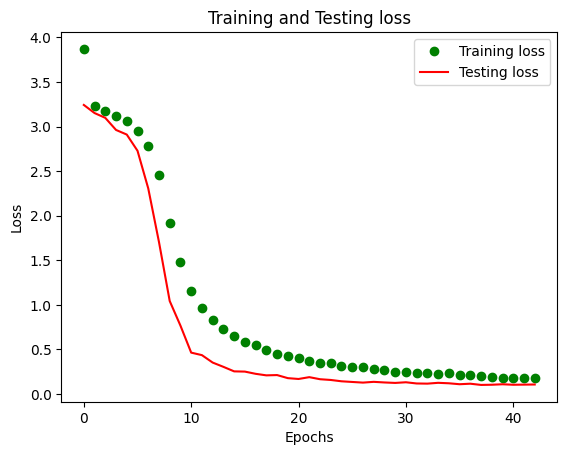

In [20]:
training_acc = model_history.history['accuracy']
testing_accuracy = model_history.history['val_accuracy']
training_loss = model_history.history['loss']
testing_loss = model_history.history['val_loss']
epochs = range(len(testing_accuracy))

# Plotting accuracy
plt.plot(epochs, training_acc, 'go', label='Training accuracy')  # Change color to green
plt.plot(epochs, testing_accuracy, 'r', label='Testing accuracy')   # Change color to red
plt.title('Training and Testing accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.figure()
plt.plot(epochs, training_loss, 'go', label='Training loss')  
plt.plot(epochs, testing_loss, 'r', label='Testing loss')       
plt.title('Training and Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<h1>Predict Label</h1>

<h2>Predicting Correct Labels</h2>

In [21]:
test_label_1d = test_label.squeeze()

105/105 [==============================] - 2s 15ms/step
Found 3259 correct labels


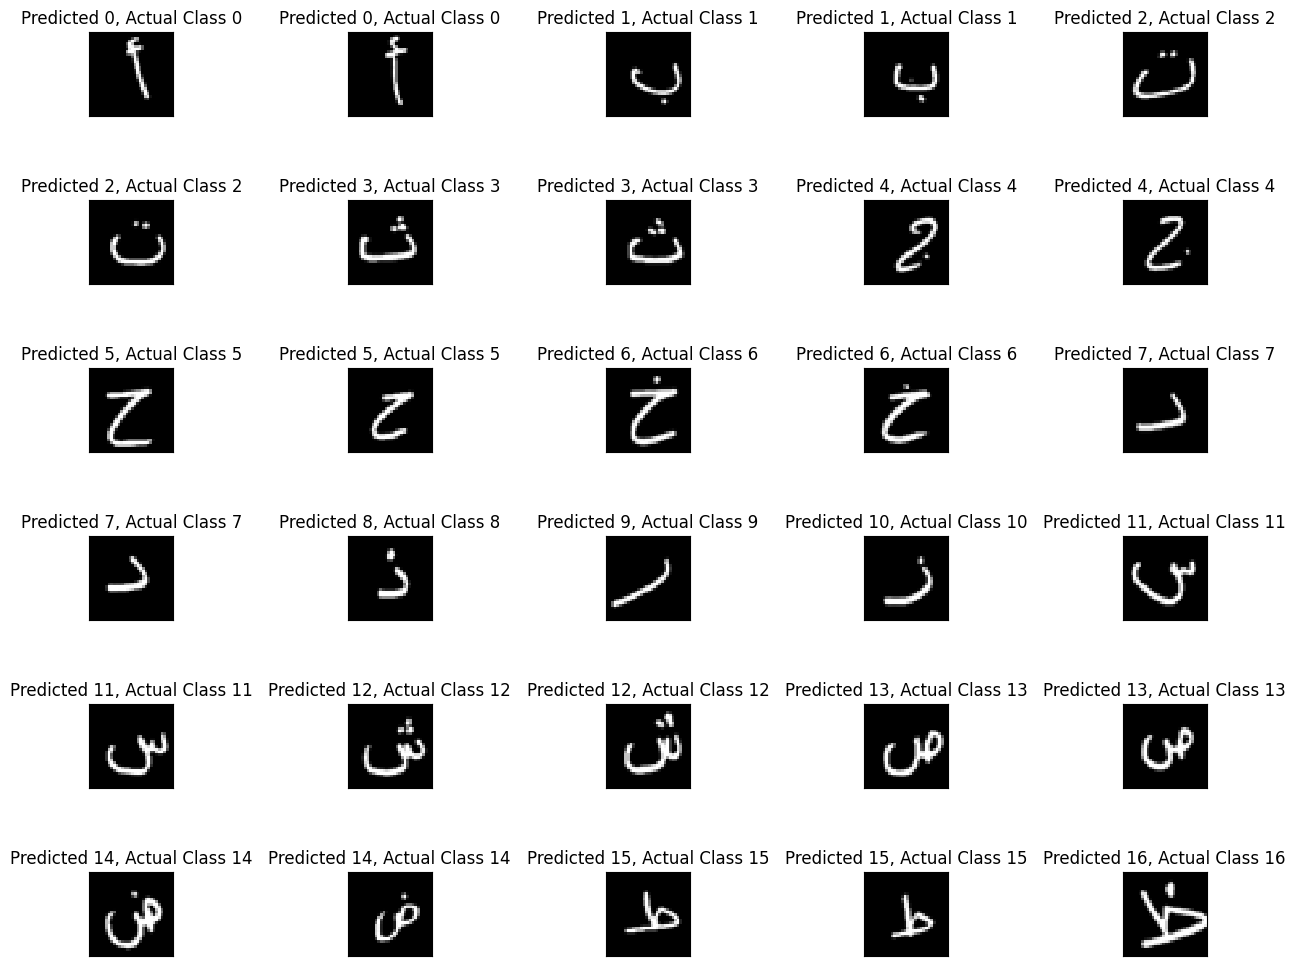

In [22]:
predicted_classes= model.predict(test_images)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

correct = np.where(predicted_classes == test_label_1d)[0]
print("Found %d correct labels" % len(correct))

plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=1, wspace=1)

for i, idx in enumerate(correct[:30]):
    plt.subplot(6,5, i + 1)

    plt.imshow(test_images[idx, :, :, 0].T, cmap='gray', interpolation='none')
    plt.title("Predicted {}, Actual Class {}".format(predicted_classes[idx], test_label_1d[idx]))
    plt.xticks([]) 
    plt.yticks([]) 

plt.show()

<h2>Predicting Incorrect Labels</h2>

Found 101 incorrect labels


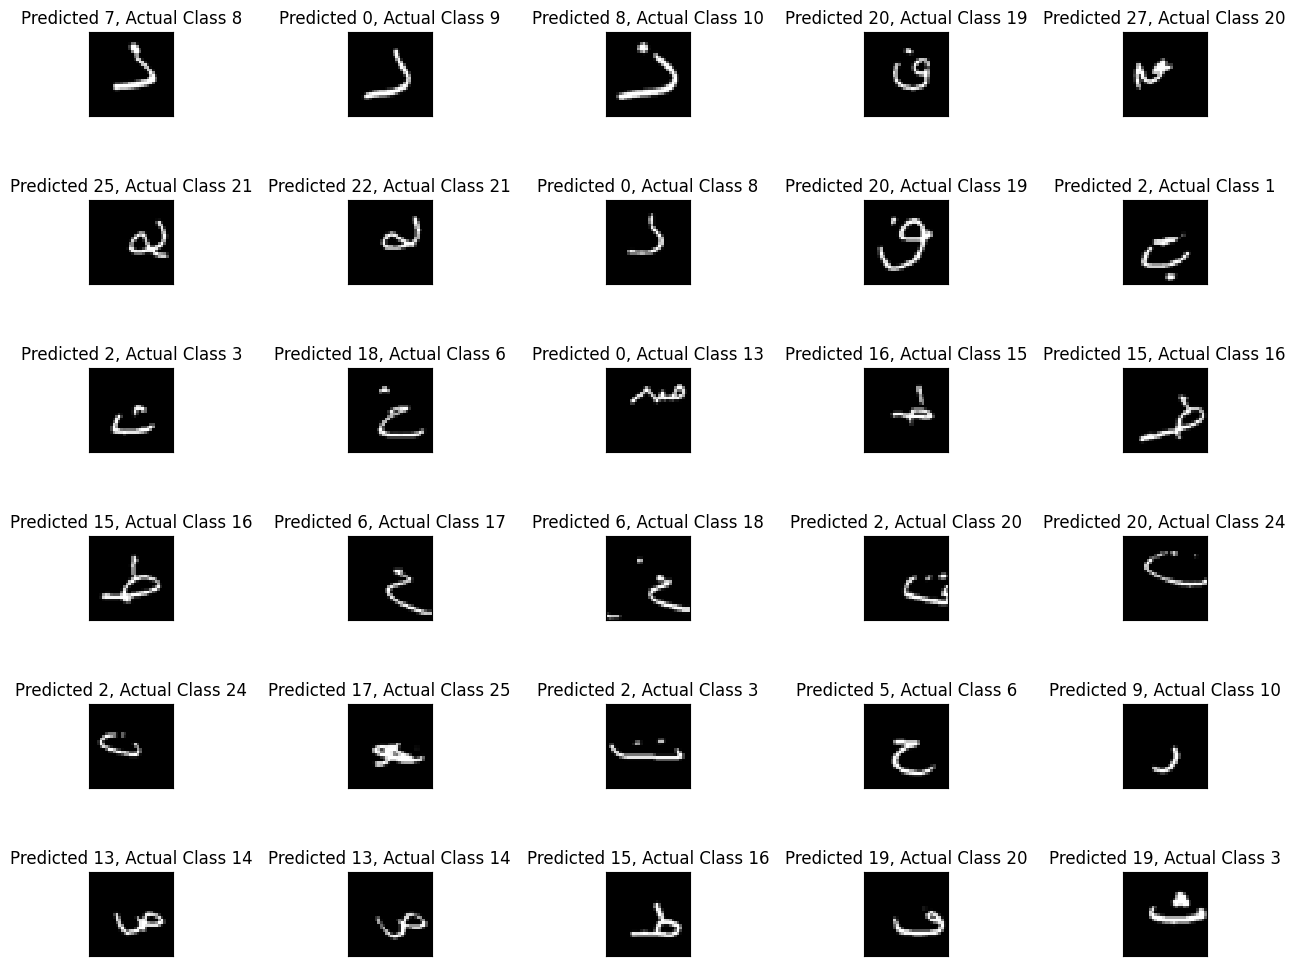

In [23]:
incorrect = np.where(predicted_classes != test_label_1d)[0]
print("Found %d incorrect labels" % len(incorrect))

plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=1, wspace=1)

for i, idx in enumerate(incorrect[:30]):
    plt.subplot(6,5, i + 1) 

    plt.imshow(test_images[idx, :, :, 0].T, cmap='gray', interpolation='none')
    plt.title("Predicted {}, Actual Class {}".format(predicted_classes [idx], test_label_1d[idx]))
    plt.xticks([]) 
    plt.yticks([]) 

plt.show()


The utilization of the "Fine Tuning" transfer learning approach, where modifications are made to the top layers while keeping the lower layers frozen, resulted in a notable improvement. This is evident in the fact that the number of correct labels increased to 3259, while the count of incorrect labels reduced to 101. The code removes the last layer of the base model and introduces a new Dense layer with 28 units, effectively customizing the model for a specific task. Importantly, only the weights of the top layers undergo further training, allowing the model to benefit from pre-existing knowledge while adapting to the task at hand..